##### Figure 4
# HRRR forecasts hovemoller and pollywogs

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_wx_calcs.wind import wind_uv_to_spd, wind_spddir_to_uv

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b-%d\n%H:%M')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [two_column, 3]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .2
mpl.rcParams['grid.alpha'] = .8
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


In [3]:
# Get Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/hrrr/'
latlon_file = h5py.File(DIR+'HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [4]:
sDATE = datetime(2017, 10, 8, 0)
eDATE = datetime(2017, 10, 10, 1)

stn = 'HWKC1'
# ----------------------------------------------
location_dic = get_MW_location_dict(stn)
H = {'lat':lat, 'lon':lon}

x, y = pluck_hrrr_point(H, location_dic[stn]['latitude'], location_dic[stn]['longitude'],
                        XY_only=True)

 >> Requested Center lat: 38.735086	 lon: -122.837058
 >>     Plucked HRRR lat: 38.73599	 lon: -122.83093
 >>     Plucked from   x: 638	   y: 176


#### Get the hovmoller array
Since we are not plotting wind directions, We do not need to convert the vectors to earth-relative. We can increase the speed by downloading UGRD and VGRD separately and then computing the wind speed.

In [5]:
U_hovmoller = LocDic_hrrr_hovmoller(sDATE, eDATE, location_dic,
                                  variable='UGRD:10 m',
                                  forecasts=range(19),
                                  area_stats=False,
                                  reduce_CPUs=2,
                                  verbose=True)

V_hovmoller = LocDic_hrrr_hovmoller(sDATE, eDATE, location_dic,
                                  variable='VGRD:10 m',
                                  forecasts=range(19),
                                  area_stats=False,
                                  reduce_CPUs=2,
                                  verbose=True)

LocDic Time Series F00: Finished multiprocessing in 0:00:05.601895 on 22 processors
LocDic Time Series F01: Finished multiprocessing in 0:00:06.388807 on 22 processors
LocDic Time Series F02: Finished multiprocessing in 0:00:05.980796 on 22 processors
LocDic Time Series F03: Finished multiprocessing in 0:00:05.961590 on 22 processors
LocDic Time Series F04: Finished multiprocessing in 0:00:05.718256 on 22 processors
LocDic Time Series F05: Finished multiprocessing in 0:00:06.009169 on 22 processors
LocDic Time Series F06: Finished multiprocessing in 0:00:05.853227 on 22 processors
LocDic Time Series F07: Finished multiprocessing in 0:00:05.140598 on 22 processors
LocDic Time Series F08: Finished multiprocessing in 0:00:06.062227 on 22 processors
LocDic Time Series F09: Finished multiprocessing in 0:00:05.169083 on 22 processors
LocDic Time Series F10: Finished multiprocessing in 0:00:05.161736 on 22 processors
LocDic Time Series F11: Finished multiprocessing in 0:00:05.538046 on 22 pro

In [6]:
speed = wind_uv_to_spd(U_hovmoller[stn], V_hovmoller[stn])

In [7]:
VALIDDATES = U_hovmoller['valid_1d+']

In [5]:
# Get mesowest observations
a = get_mesowest_ts(stn, sDATE-timedelta(hours=1), eDATE+timedelta(hours=1))

In [7]:
a['wind_speed'].max()

21.460000000000001

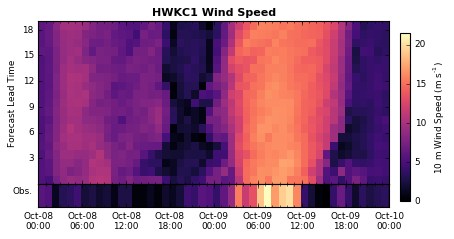

In [9]:
vmax = np.nanmax([np.nanmax(speed), np.nanmax(a['wind_speed'])])
vmin = 0
cmap = 'magma'
xlim = [sDATE, eDATE-timedelta(hours=1)]

fig = plt.figure(1)
ax1 = plt.subplot2grid((8, 1), (0, 0), rowspan=7)
ax2 = plt.subplot(8, 1, 8)

hv = ax1.pcolormesh(VALIDDATES, U_hovmoller['fxx_1d+'], speed,
                    cmap=cmap,
                    vmax=vmax, vmin=vmin)
mw = ax2.pcolormesh(a['DATETIME'], range(2), [a['wind_speed'], a['wind_speed']],
                    cmap=cmap,
                    vmax=vmax, vmin=vmin)

ax1.axes.xaxis.set_ticklabels([])
ax1.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
ax1.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
ax2.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
ax2.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim([0, 19])
ax1.set_yticks(range(3,19,3))
ax1.set_xlim(xlim)
ax1.set_ylabel('Forecast Lead Time')

ax2.set_yticks([])
ax2.set_xlim(xlim)
ax2.set_ylabel('Obs.', rotation=0, ha='right')

ax1.set_title(stn + ' Wind Speed', fontweight='semibold')

fig.subplots_adjust(hspace=0, right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cb = fig.colorbar(hv, cax=cbar_ax, ticks=range(0,25,5))
cb.ax.set_ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

plt.savefig('./figs/Fig_04a_%s_hovmoller' % stn)

# HRRR Pollywog

In [10]:
# Extract Pollywog from Hovmoller array
hours_from_sDATE = range(0, np.shape(speed)[1])
pollywogs = {}
for index in hours_from_sDATE:
    validtime = []
    pollywog = []
    for f in range(19):
        try:
            pollywog.append(speed[f, f+index])
            validtime.append(VALIDDATES[index]+timedelta(hours=f))
        except:
            # data out of range of what was retrieved
            pass
    pollywogs[index] = {'valid': validtime,
                        'polly': pollywog}

In [11]:
# Retrieve Percentiles
def get_point_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT, ROW, COL = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT][x][y]
    except:
        #print "COULD NOT GET", FILE
        return np.nan

In [12]:
percentiles = [0, 1, 2, 3, 4, 5, 25, 50, 75, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'
fxx = 0
hours = range(24)

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

HTS = OrderedDict()
for i, pp in enumerate(percentiles):
    # Multiprocessing :)
    stat = 'p%02d' % pp
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, D.month, D.day, D.hour), stat, x, y] for D in VALIDDATES]
    timer = datetime.now()
    num_proc = multiprocessing.cpu_count()
    p = multiprocessing.Pool(num_proc)
    HTS[stat] = np.array(p.map(get_point_MP, args))
    p.close()

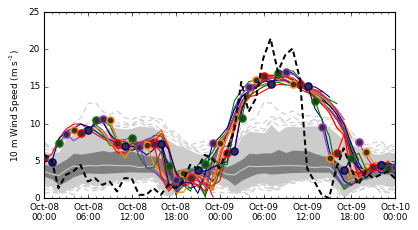

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0, right=0.8)
# Background OSG Percentiles
plt.fill_between(VALIDDATES,
                 HTS['p95'], HTS['p05'],
                 facecolor=[.8, .8, .8],
                 linewidth=0,
                 label='HRRR p05-p95')
plt.fill_between(VALIDDATES,
                 HTS['p75'], HTS['p25'],
                 facecolor=[.5, .5, .5],
                 linewidth=0,
                 label='HRRR p25-p75')
plt.plot(VALIDDATES,
         HTS['p50'],
         color=[.8, .8, .8],
         lw=1,
         label='HRRR p50',
         zorder=1)
for i in [1,2,3,4,96, 97, 98, 99]:
    plt.plot(VALIDDATES,
             HTS['p%02d' % i],
             color=[.8, .8, .8],
             lw=1,
             linestyle='--', dashes=(5,3),
             label='HRRR p%02d' % i,
             zorder=1)


# Cycle pollywogs through these colors.
colors = ['red', 'darkblue', 'green', 'darkorchid', 'darkorange'] * 50
color_count = 0
for p in hours_from_sDATE:
    plt.scatter(pollywogs[p]['valid'][0], pollywogs[p]['polly'][0],
                s=60,
                lw=0,
                c=colors[color_count],
                zorder=2)
    plt.plot(pollywogs[p]['valid'], pollywogs[p]['polly'],
             c=colors[color_count],
             lw=1,
             zorder=1)
    color_count += 1

plt.scatter(VALIDDATES[:-1], speed[0,:],
            c=[.2, .2, .2],
            s=25,
            lw=0,
            zorder=3)

plt.plot(a['DATETIME'], a['wind_speed'],
         color='k',
         linestyle='--', dashes=(5, 3),
         zorder=5)

plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))

plt.xlim(xlim)
plt.ylim([0,25])

plt.ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

#plt.title(stn + ' Wind Speed', fontweight='semibold')
plt.savefig('./figs/Fig_04b_%s_timeseries_pollywog_percentiles_mesowest' % (stn))